In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

MAX_GRAD_NORM = 0.5

TRAIN_DATA_PATH = "../../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/CICFlowMeter/CICFlowMeter_Training_Balanced.csv"
TEST_DATA_PATH = "../../DNP3_Intrusion_Detection_Dataset_Final/Training_Testing_Balanced_CSV_Files/CICFlowMeter/CICFlowMeter_Testing_Balanced.csv"

# CSVファイルの読み込み
raw_data_train = pd.read_csv(TRAIN_DATA_PATH).replace([np.inf, -np.inf], np.nan).dropna(how="all").dropna(how="all", axis=1)
raw_data_test = pd.read_csv(TEST_DATA_PATH).dropna(how="all").replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=1)

raw_data_train["Binary Label"] = raw_data_train["Label"] == "NORMAL"
raw_data_test["Binary Label"] = raw_data_test["Label"] == "NORMAL"

train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)

In [3]:
class A2C(nn.Module):

    def __init__(self, env, hidden_size=128, gamma=.99, random_seed=None):
        """
        Assumes fixed continuous observation space
        and fixed discrete action space (for now)

        :param env: target gym environment
        :param gamma: the discount factor parameter for expected reward function :float
        :param random_seed: random seed for experiment reproducibility :float, int, str
        """
        super().__init__()

        if random_seed:
            env.seed(random_seed)
            torch.manual_seed(random_seed)

        self.env = env
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.in_size = len(env.observation_space.sample().flatten())
        self.out_size = self.env.action_space.n

        self.actor = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.out_size)
        ).double()

        self.critic = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        ).double()

    def train_env_episode(self, render=False):
        """
        Runs one episode and collects critic values, expected return,
        :return: A tensor with total/expected reward, critic eval, and action information
        """
        rewards = []
        critic_vals = []
        action_lp_vals = []

        # Run episode and save information

        observation, _ = self.env.reset()
        done = False
        while not done:
            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()
            # print(observation)
            if torch.isnan(observation).any():
                observation = torch.nan_to_num(observation, nan=0.0)
            # Get action from actor
            action_logits = self.actor(observation)
            # print(action_logits)
            action = Categorical(logits=action_logits).sample()

            # Get action probability
            action_log_prob = action_logits[action]

            # Get value from critic
            pred = torch.squeeze(self.critic(observation).view(-1))

            # Write prediction and action/probabilities to arrays
            action_lp_vals.append(action_log_prob)
            critic_vals.append(pred)

            # Send action to environment and get rewards, next state

            observation, reward, done, _, info = self.env.step(action.item())
            rewards.append(torch.tensor(reward).double())

        total_reward = sum(rewards)

        # Convert reward array to expected return and standardize
        for t_i in range(len(rewards)):
            G = 0
            for t in range(t_i, len(rewards)):
                G += rewards[t] * (self.gamma ** (t - t_i))
            rewards[t_i] = G

        # Convert output arrays to tensors using torch.stack
        def f(inp):
            return torch.stack(tuple(inp), 0)

        # Standardize rewards
        rewards = f(rewards)
        rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + .000000000001)

        return rewards, f(critic_vals), f(action_lp_vals), total_reward

    def test_env_episode(self, render=True):
        """
        Run an episode of the environment in test mode
        :param render: Toggle rendering of environment :bool
        :return: Total reward :int
        """
        observation, _ = self.env.reset()
        rewards = []
        done = False
        while not done:

            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()

            # Get action from actor
            action_logits = self.actor(observation)
            action = Categorical(logits=action_logits).sample()

            observation, reward, done, _, info = self.env.step(action.item())
            rewards.append(reward)

        return sum(rewards)

    @staticmethod
    def compute_loss(action_p_vals, G, V, critic_loss=nn.SmoothL1Loss()):
        """
        Actor Advantage Loss, where advantage = G - V
        Critic Loss, using mean squared error
        :param critic_loss: loss function for critic   :Pytorch loss module
        :param action_p_vals: Action Log Probabilities  :Tensor
        :param G: Actual Expected Returns   :Tensor
        :param V: Predicted Expected Returns    :Tensor
        :return: Actor loss tensor, Critic loss tensor  :Tensor
        """
        assert len(action_p_vals) == len(G) == len(V)
        advantage = G - V.detach()
        return -(torch.sum(action_p_vals * advantage)), critic_loss(G, V)

In [4]:
# def _update(frame, x, y):
#     global critic_loss
#     """グラフを更新するための関数"""
#     # 現在のグラフを消去する
#     plt.cla()
#     # データを更新 (追加) する
#     print(frame)
#     x.append(frame)
#     y.append(critic_loss[int(frame)])
#     # 折れ線グラフを再描画する
#     plt.plot(x, y)

In [5]:
def plot_rewards(episode_rewards, show_result=False, num_episodes=-1):

    # plt.figure(1)
    plt.figure(figsize=(15, 4))

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")

    result = pd.DataFrame(episode_rewards, columns=["Episode", "Total Reward"])
    result["Mean"] = result["Total Reward"].rolling(window=100, min_periods=1).mean()
    plt.plot(result["Episode"], result["Total Reward"])
    plt.plot(result["Episode"], result["Mean"], label="Mean", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()

    plt.legend()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

<Figure size 640x480 with 0 Axes>

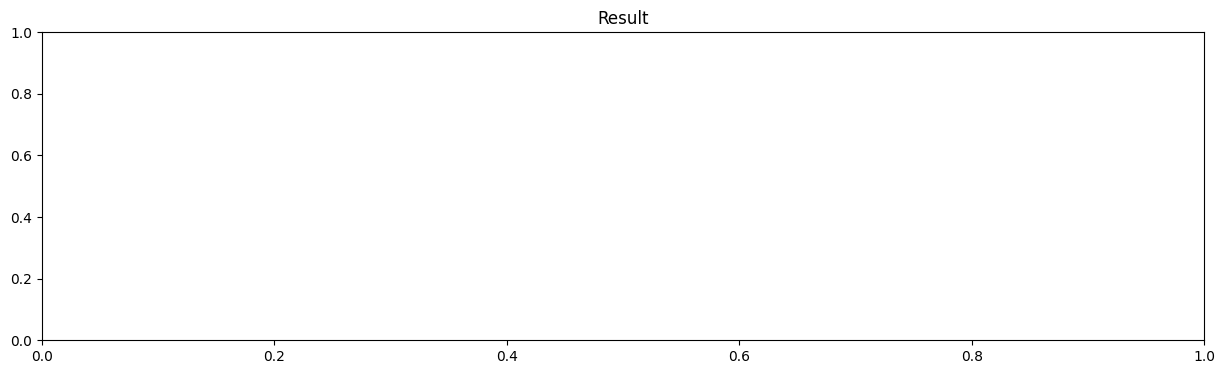

In [6]:

"""
Cart-pole reinforcement learning environment:
Agent learns to balance a pole on a cart

a2c: Agent uses Advantage Actor Critic algorithm

"""
LR = .01  # Learning rate
SEED = None  # Random seed for reproducibility
MAX_EPISODES = 10000  # Max number of episodes

# Init actor-critic agent
agent = A2C(train_env, random_seed=SEED)

# Init optimizers
actor_optim = optim.Adam(agent.actor.parameters(), lr=LR)
critic_optim = optim.Adam(agent.critic.parameters(), lr=LR)

#
# Train
#

r = []  # Array containing total rewards
sum_rewards = []
avg_r = 0  # Value storing average reward over last 100 episodes

actor_loss = []
critic_loss = []


for i in range(MAX_EPISODES):
    critic_optim.zero_grad()
    actor_optim.zero_grad()

    rewards, critic_vals, action_lp_vals, total_reward = agent.train_env_episode(render=False)
    r.append(total_reward)
    sum_rewards.append([i, total_reward])
    plot_rewards(sum_rewards)

    l_actor, l_critic = agent.compute_loss(action_p_vals=action_lp_vals, G=rewards, V=critic_vals)
    actor_loss.append(l_actor.detach().numpy())
    critic_loss.append(l_critic.detach().numpy())

    l_actor.backward()
    l_critic.backward()

    # for name, param in agent.actor.named_parameters():
    #     if param.grad is not None:
    #         print(f"Actor gradient for {name}: {param.grad}")
    #
    # # Print gradients for critic
    # for name, param in agent.critic.named_parameters():
    #     if param.grad is not None:
    #         print(f"Critic gradient for {name}: {param.grad}")

    utils.clip_grad_norm_(agent.actor.parameters(), MAX_GRAD_NORM)
    utils.clip_grad_norm_(agent.critic.parameters(), MAX_GRAD_NORM)

    actor_optim.step()
    critic_optim.step()

    # Check average reward every 100 episodes, print, and end script if solved
    if len(r) >= 100:  # check average every 100 episodes

        episode_count = i - (i % 100)
        prev_episodes = r[len(r) - 100:]
        avg_r = sum(prev_episodes) / len(prev_episodes)
        # if len(r) % 100 == 0:
        #     print(f'Average reward during episodes {episode_count:3}-{episode_count+100} is {avg_r.item()}')
        if avg_r > 195:
            # print(f"Solved CartPole-v1 with average reward {avg_r.item()}")
            break
plot_rewards(r, show_result=True)
# print()

#
# Test
#
# for _ in range(100):
#     agent.test_env_episode(render=True)

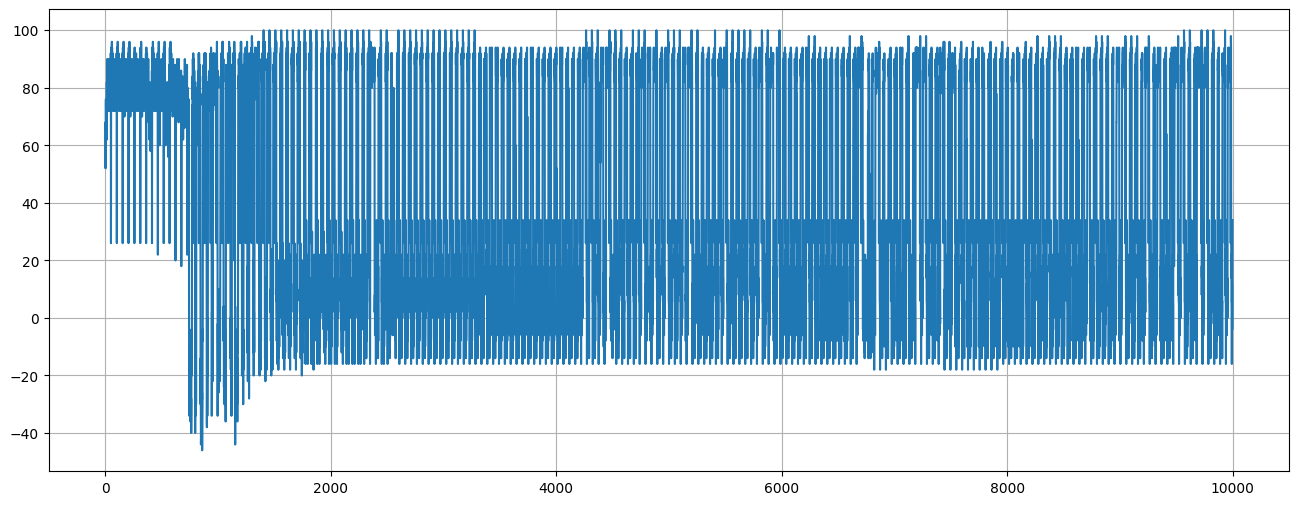

In [13]:
plt.figure(figsize=(16,6))
result = pd.DataFrame(sum_rewards, columns=["Episode", "reward"])
plt.plot(result["Episode"], result["reward"])
plt.grid()

In [12]:
torch.save(agent.state_dict(), "a2c_10000.pth")